In [1]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/\(데이콘\)태양광발전량예측/data ./

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K

In [41]:
df = pd.read_csv('./data/train/train.csv', sep=',')
df = df.drop(columns=['Day', 'Hour', 'Minute', 'WS'])
data = df.values
print(data.shape)

(52560, 5)


In [ ]:
data

array([[  0.  ,   0.  ,  69.08, -12.  ,   0.  ],
       [  0.  ,   0.  ,  69.06, -12.  ,   0.  ],
       [  0.  ,   0.  ,  71.78, -12.  ,   0.  ],
       ...,
       [  0.  ,   0.  ,  66.78,  -4.  ,   0.  ],
       [  0.  ,   0.  ,  67.72,  -4.  ,   0.  ],
       [  0.  ,   0.  ,  67.7 ,  -4.  ,   0.  ]])

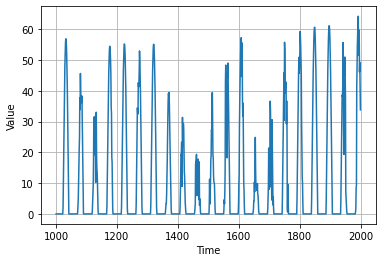

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plot_series(np.arange(len(data)), data[:, -1], start=1000, end=2000)

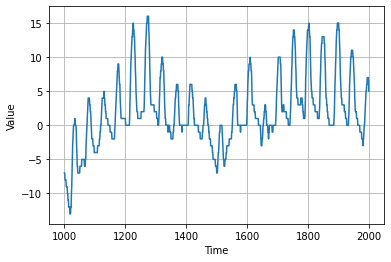

In [ ]:
plot_series(np.arange(len(data)), data[:, -2], start=1000, end=2000)

In [53]:
time = np.arange(len(data))
print(len(data))

split_time = 45000
time_train = time[:split_time]
x_train = data[:split_time]
time_valid = time[split_time:]
x_valid = data[split_time:]

window_size = 48 * 7
batch_size = 128
shuffle_buffer_size = 1000

52560


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  ds = tf.data.Dataset.from_tensor_slices(series) # (45000, 5)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [8]:
def tilted_loss(q,y,f):
  e = (y-f)
  return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [44]:
tf.keras.backend.clear_session()
tf.random.set_seed(77)
np.random.seed(77)

train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
# qs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# qs = [0.2, 0.3]
qs = [0.5]

models = []
for q in qs:
  tf.keras.backend.clear_session()
  tf.random.set_seed(77)
  np.random.seed(77)
  
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=120, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 5]),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=120, kernel_size=5, padding="causal", activation="relu"),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(30, activation="relu"),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5)
  ])


  optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-4 / 800)
  model.compile(loss=lambda y,f: tilted_loss(q,y,f),
                optimizer=optimizer,
                metrics=["mae"])
  history = model.fit(train_set,epochs=800)
  models.append((history, model))

Epoch 1/800
349/349 [==============================] - 34s 84ms/step - loss: 37.3032 - mae: 74.6063
Epoch 2/800
349/349 [==============================] - 30s 85ms/step - loss: 37.0979 - mae: 74.1958
Epoch 3/800
349/349 [==============================] - 30s 84ms/step - loss: 36.9107 - mae: 73.8214
Epoch 4/800
349/349 [==============================] - 30s 84ms/step - loss: 36.6724 - mae: 73.3449
Epoch 5/800
349/349 [==============================] - 30s 84ms/step - loss: 36.3114 - mae: 72.6228
Epoch 6/800
349/349 [==============================] - 29s 84ms/step - loss: 35.8059 - mae: 71.6117
Epoch 7/800
349/349 [==============================] - 29s 83ms/step - loss: 35.0883 - mae: 70.1767
Epoch 8/800
349/349 [==============================] - 30s 84ms/step - loss: 34.1302 - mae: 68.2603
Epoch 9/800
349/349 [==============================] - 29s 84ms/step - loss: 33.0431 - mae: 66.0862
Epoch 10/800
349/349 [==============================] - 30s 86ms/step - loss: 31.8896 - mae: 63.7792

KeyboardInterrupt: ignored

In [ ]:
models[0][1].save('model2.h5')
models[1][1].save('model3.h5')

In [45]:
models[0][1].save('mmodel1.h5')

IndexError: ignored

In [52]:
model.save('mmodel1.h5')

In [ ]:
!cp ./model1.h5 /content/drive/MyDrive/Colab\ Notebooks/\(데이콘\)태양광발전량예측

In [46]:
plt.plot(history.history['loss'])

NameError: ignored

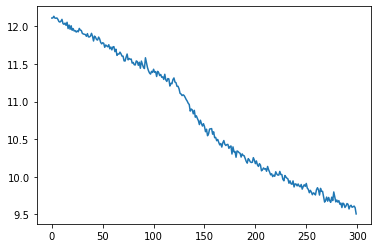

In [ ]:
plt.plot(history.history['loss'][200:])

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/(데이콘)태양광발전량예측/model5.h5')

In [47]:
rnn_forecast = model_forecast(model, data, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, :]

In [ ]:
rnn_forecast.shape

(7560, 6)

In [ ]:
len(time_valid)

7560

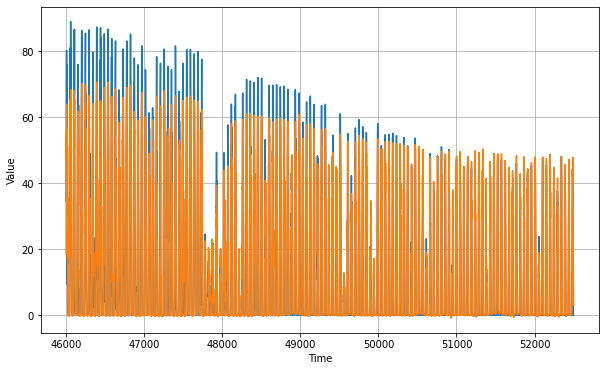

In [51]:
start = 1000
end = 7500
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid[:,-1], start=start, end=end)
plot_series(time_valid, rnn_forecast[:,-1], start=start, end=end)

In [ ]:
# WS 빼고 ㄱㄱ
# 시드통일 ㄱㄱ

In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 5]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(5)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-4 / 500)
model.compile(loss=lambda y,f: tilted_loss(q,y,f),
              optimizer=optimizer,
              metrics=["mae"])

In [16]:
tests = []
for i in range(81):
  df = pd.read_csv('./data/test/%d.csv'%i, sep=',')
  df = df.drop(columns=['Day', 'Hour', 'Minute', 'WS'])
  data = df.values
  tests.append(data)
tests = np.array(tests)
print(tests.shape)

(81, 336, 5)


In [17]:
import copy

_2day = np.zeros((81, 48*2, 5)) # (num, 2day, columns)
_7day = copy.deepcopy(tests)

for i in range(48*2):
  print('30min : ', i)

  for j in range(1, 10):
    print(j, end='')
    model.load_weights('/content/drive/MyDrive/Colab Notebooks/(데이콘)태양광발전량예측/model%d.h5'%j)

    for k in range(81):
      rnn_forecast = model_forecast(model, _7day[k], window_size)
      new_time30 = rnn_forecast[-1, -1, :] # (num_windows, window, columns) # (5,)
      _2day[k, i, :] += new_time30
      
  print()

  _2day[:, i, :] /= 9
  _7day = np.concatenate((_7day[:, i+1:, :], _2day[:, :i+1, :]), axis=1) # (48*7, 5)

_9day = copy.deepcopy(tests)
_9day = np.concatenate((_9day, _2day), axis=1)

30min :  0
123456789
30min :  1
123456789
30min :  2
123456789
30min :  3
123456789
30min :  4
123456789
30min :  5
123456789
30min :  6
123456789
30min :  7
123456789
30min :  8
123456789
30min :  9
123456789
30min :  10
123456789
30min :  11
123456789
30min :  12
123456789
30min :  13
123456789
30min :  14
123456789
30min :  15
123456789
30min :  16
123456789
30min :  17
123456789
30min :  18
123456789
30min :  19
123456789
30min :  20
123456789
30min :  21
123456789
30min :  22
123456789
30min :  23
123456789
30min :  24
123456789
30min :  25
123456789
30min :  26
123456789
30min :  27
123456789
30min :  28
123456789
30min :  29
123456789
30min :  30
123456789
30min :  31
123456789
30min :  32
123456789
30min :  33
123456789
30min :  34
123456789
30min :  35
123456789
30min :  36
123456789
30min :  37
123456789
30min :  38
123456789
30min :  39
123456789
30min :  40
123456789
30min :  41
123456789
30min :  42
123456789
30min :  43
123456789
30min :  44
123456789
30min :  45
12345678

In [18]:
qts = np.zeros((9, 81, 48*2))

for j in range(1,10):
  print('quantile : 0.', j)
  model.load_weights('/content/drive/MyDrive/Colab Notebooks/(데이콘)태양광발전량예측/model%d.h5'%j)

  for i in range(81):
    print('.', end=' ')
    rnn_forecast = model_forecast(model, _9day[i], window_size)
    qt_2day = rnn_forecast[1:, -1, -1] # (num_windows, window, columns) # (48*2)
    assert len(qt_2day) == 48*2
    qts[j-1, i, :] = qt_2day

  print()

qts = qts.reshape(9, -1)
qts = qts.T
qts.shape

quantile : 0. 1
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
quantile : 0. 2
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
quantile : 0. 3
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
quantile : 0. 4
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
quantile : 0. 5
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
quantile : 0. 6
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

(7776, 9)

In [38]:
df = pd.read_csv('./data/sample_submission.csv', sep=',')
qts[qts < 0] = 0
df.iloc[:,1:] = qts
df.to_csv('./submission1.csv', index=False)

In [36]:
df.iloc[:,1:] = qts
df.iloc[:,1:]

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,-0.001185,-0.000156,0.000145,7.260241,18.976295,10.077131,0.038612,7.869984,0.240643
1,4.987893,10.555059,9.401020,16.038935,15.848911,10.341256,0.780075,12.051487,0.247137
2,10.703866,13.426122,10.345375,9.133416,9.424044,9.426341,2.223816,2.920774,0.247387
3,16.574596,12.656937,17.108545,16.781837,20.026453,21.029512,5.896090,1.759565,0.974012
4,21.912746,16.060734,22.170261,27.080751,28.625237,35.232468,11.735057,8.174693,18.611628
...,...,...,...,...,...,...,...,...,...
7771,11.493590,14.961251,23.688454,21.361797,28.006895,25.841568,19.671518,23.023960,45.148846
7772,11.475927,15.462106,23.748093,21.395914,28.060301,25.839069,19.880007,22.774168,45.438095
7773,11.581779,16.038765,23.961739,21.421431,28.134613,25.846542,19.561502,22.763025,46.149628
7774,11.890716,16.518528,24.633739,21.442024,28.163744,25.785471,18.971123,23.436363,46.677048


In [ ]:
df = pd.read_csv('./data/sample_submission.csv', sep=',')
print(df.values[:,1:].shape)

(7776, 9)


In [ ]:
dd + bb

array([[ 4,  8, 12, 16]])

In [ ]:
aa = np.array([[]])
bb = np.array([[2,4,6,8]])
dd = np.array([[2,4,6,8]])
cc = np.concatenate((aa,bb, dd), axis=0)
cc.shape

ValueError: ignored

In [ ]:
rnn_forecast = model_forecast(model, tests[0], window_size)

In [ ]:
rnn_forecast.shape

(1, 336, 5)

In [ ]:
aa = np.array([1,2,3,4]).reshape(1,-1)
bb = np.array([2,4,6,8]).reshape(1,-1)
cc = np.concatenate((aa,bb), axis=0).T
cc

array([[1, 2],
       [2, 4],
       [3, 6],
       [4, 8]])

In [ ]:
aa = np.arange(336*5).reshape(336,5)
bb = np.arange(5).reshape(1,5)
cc = np.concatenate((aa,bb), axis=0)
cc.shape

(337, 5)

In [ ]:
model.save('model.h5')